In [1]:
import diffusers
from diffusers.models import UNet2DModel

model=UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32,64,64),
    down_block_types=("DownBlock2D","AttnDownBlock2D","AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D","AttnUpBlock2D","UpBlock2D")
    )

print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleLis

In [3]:
sum([p.numel() for p in model.parameters()])

1707009

In [4]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset = torchvision.datasets.MNIST(
    root="/data/sshadmin/bocheng/data/torchvision/mnist/",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)

Using device: cuda
Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([7, 2, 5, 5, 0, 8, 6, 0])


In [6]:
def corrupt(x, amount):
    noise = torch.rand_like(x)  # 噪声
    amount = amount.view(-1, 1, 1, 1)
    return x * (1 - amount) + noise * amount

Finished epoch 0. Average loss for this epoch: 0.019542
Finished epoch 1. Average loss for this epoch: 0.012880
Finished epoch 2. Average loss for this epoch: 0.011638


Text(0.5, 1.0, 'Loss over time')

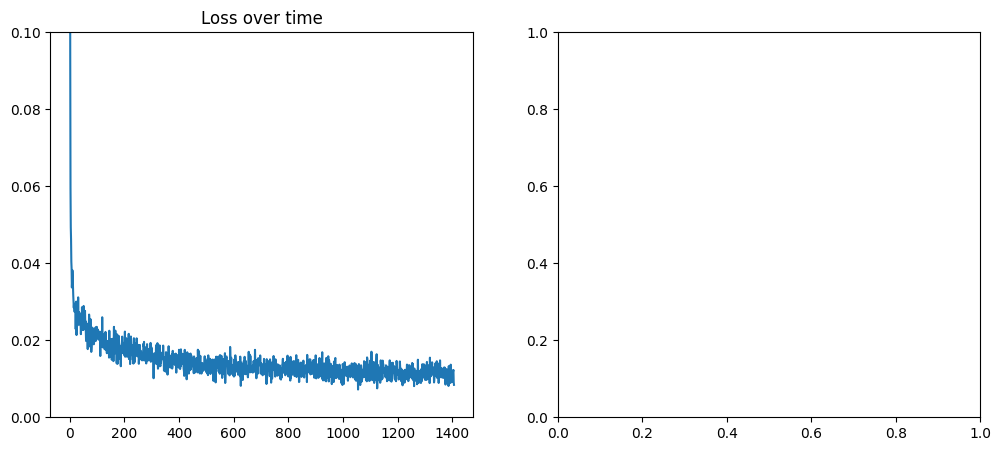

In [7]:
batch_size=128
train_dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=True)
n_epochs=3
model.to(device)
loss_fn=nn.MSELoss()
opt=torch.optim.Adam(model.parameters(),lr=1e-3)

losses=[]

for epoch in range(n_epochs):
    for x,y in train_dataloader:
        x=x.to(device)
        noise_amount=torch.rand(x.shape[0]).to(device)
        noise_y=corrupt(x,noise_amount)
        pred=model(noise_y,0).sample

        loss=loss_fn(pred,x)
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
    avg_loss=sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')


# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

Text(0.5, 1.0, 'Generated Samples')

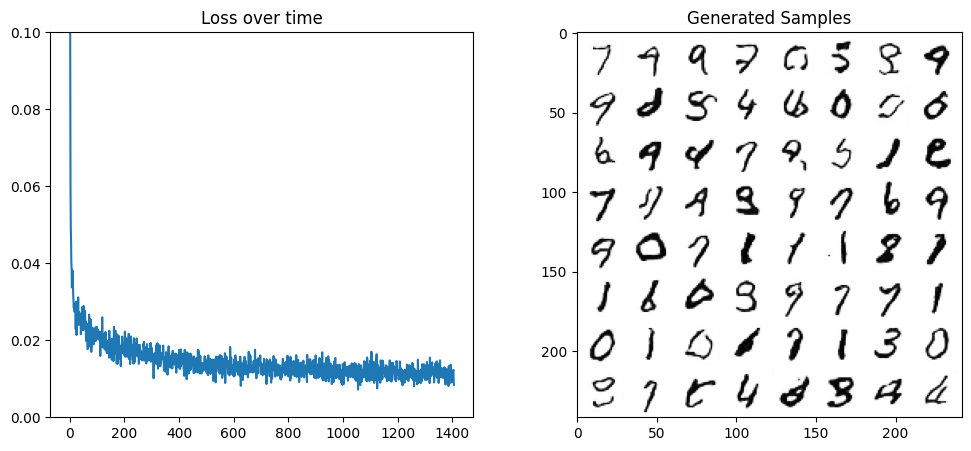

In [8]:
# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = model(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples')